In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from IPython.display import display
from torch.optim.lr_scheduler import StepLR

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((30, 30)),
    transforms.RandomRotation(5),
    transforms.RandomAffine(0, translate=(0.05, 0.05)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.Resize((30, 30)),
    transforms.ToTensor()
])

train_data = torchvision.datasets.GTSRB(root='./data', split='train', download=True, transform=transform_train)

100%|██████████| 187M/187M [00:12<00:00, 15.0MB/s]


In [ ]:
train_data

Dataset GTSRB
    Number of datapoints: 26640
    Root location: ./data
    StandardTransform
Transform: Compose(
               Resize(size=(30, 30), interpolation=bilinear, max_size=None, antialias=True)
               RandomRotation(degrees=[-5.0, 5.0], interpolation=nearest, expand=False, fill=0)
               RandomAffine(degrees=[0.0, 0.0], translate=(0.05, 0.05))
               ColorJitter(brightness=(0.9, 1.1), contrast=(0.9, 1.1), saturation=None, hue=None)
               ToTensor()
           )

In [ ]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

In [ ]:
test_data = torchvision.datasets.GTSRB(root='./data', split='test', download=True, transform=transform_test)
test_data

100%|██████████| 89.0M/89.0M [00:05<00:00, 16.6MB/s]
100%|██████████| 99.6k/99.6k [00:00<00:00, 220kB/s]


Dataset GTSRB
    Number of datapoints: 12630
    Root location: ./data
    StandardTransform
Transform: Compose(
               Resize(size=(30, 30), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [ ]:
L = [0 for i in range(43)]
for img, label in train_data:
  L[label] += 1
print(L)

[150, 1500, 1500, 960, 1320, 1260, 300, 960, 960, 990, 1350, 900, 1410, 1440, 540, 420, 300, 750, 810, 150, 240, 240, 270, 360, 180, 1020, 420, 180, 360, 180, 300, 540, 180, 480, 300, 810, 270, 150, 1380, 210, 240, 180, 180]


torch.Size([3, 30, 30])


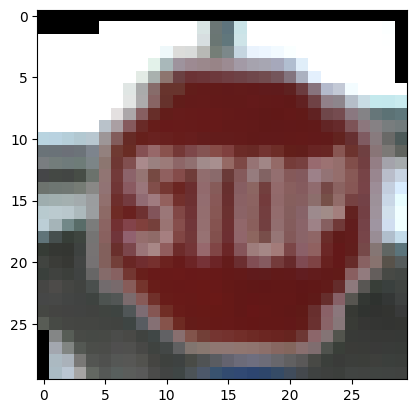

14


In [ ]:
img, label = train_data[15200]
print(img.shape)
plt.imshow(img.permute(1, 2, 0))
plt.show()
print(label)

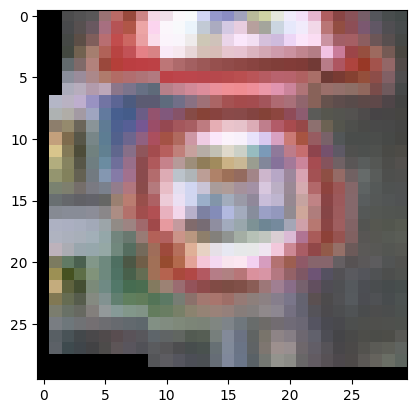

In [ ]:
conv = nn.Conv2d(3, 32, 3, 1)
for i, (X_train, y_train) in enumerate(train_data):
  break
plt.imshow(X_train.permute(1, 2, 0))
plt.show()

In [ ]:
X_train.shape

torch.Size([3, 30, 30])

In [ ]:
x = X_train.unsqueeze(0)
x = F.relu(conv(x))
x.shape

torch.Size([1, 32, 28, 28])

In [ ]:
x = F.max_pool2d(x, 2, 2)
x.shape

torch.Size([1, 32, 14, 14])

In [ ]:
conv = nn.Conv2d(32, 64, 3, 1, 1)
x = F.relu(conv(x))
print(x.shape)
x = F.max_pool2d(x, 2, 2)
print(x.shape)

torch.Size([1, 64, 14, 14])
torch.Size([1, 64, 7, 7])


In [ ]:
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, 3, 1)
    self.bn1 = nn.BatchNorm2d(16)
    self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
    self.bn2 = nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)
    self.bn3 = nn.BatchNorm2d(64)
    self.conv4 = nn.Conv2d(64, 128, 3, 1, 1)
    self.bn4 = nn.BatchNorm2d(128)
    self.dropout = nn.Dropout(0.3)
    self.fc1 = nn.Linear(128 * 7 * 7, 512)
    self.fc2 = nn.Linear(512, 43)

  def forward(self, X):
    X = F.relu(self.bn1(self.conv1(X)))
    X = F.relu(self.bn2(self.conv2(X)))
    X = F.max_pool2d(X, 2, 2)
    X = F.relu(self.bn3(self.conv3(X)))
    X = F.relu(self.bn4(self.conv4(X)))
    X = F.max_pool2d(X, 2, 2)

    X = X.view(-1, 128 * 7 * 7)

    X = self.dropout(F.relu(self.fc1(X)))
    X = self.fc2(X)
    return F.log_softmax(X, dim=1)

In [ ]:
torch.manual_seed(282)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=6272, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=43, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=2, gamma=0.5)

In [ ]:
X_test_list = []
y_test_list = []

for i in range(len(test_data)):
    image, label = test_data[i]
    X_test_list.append(image)
    y_test_list.append(label)

X_test = torch.stack(X_test_list)
y_test = torch.tensor(y_test_list)

In [ ]:
len(train_data)

26640

In [ ]:
epochs = 8
trainLosses = []
testLosses = []
trainCorrect = []
testCorrect = []
model.train()

for i in range(epochs):
  train_correct = 0
  test_correct = 0
  train_loss = 0
  for batch_id, (X_train, y_train) in enumerate(train_loader):
    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    train_loss += loss.item()

    predicted = torch.max(y_pred.data, 1)[1]
    train_correct += (predicted == y_train).sum()

    loss.backward()
    optimizer.step()
    if batch_id % 20 == 0:
      print(batch_id, end = " ")

  trainLosses.append(train_loss)
  trainCorrect.append(train_correct)
  print()
  print("Epoch: ", i, " Train Accuracy: ", train_correct.item() / len(y_train), " Average Train Loss: ", train_loss / len(train_data))

  with torch.no_grad():
    y_val = model(X_test)
    predicted = torch.max(y_val.data, 1)[1]
    test_correct += (predicted == y_test).sum()

  loss = criterion(y_val, y_test)
  testLosses.append(loss)
  testCorrect.append(test_correct)
  print("Epoch: ", i, " Test Accuracy: ", test_correct.item() / len(y_test), " Test Loss " , loss.item())

  print("Done with epoch ", i)
  scheduler.step()

0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700 720 740 760 780 800 820 
Epoch:  0  Train Accuracy:  892.6875  Average Train Loss:  0.04933879093208292
Epoch:  0  Test Accuracy:  0.8387965162311956  Test Loss  0.5178852081298828
Done with epoch  0
0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700 720 740 760 780 800 820 
Epoch:  1  Train Accuracy:  1514.5625  Average Train Loss:  0.008751510095316916
Epoch:  1  Test Accuracy:  0.8932699920823436  Test Loss  0.40652596950531006
Done with epoch  1
0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700 720 740 760 780 800 820 
Epoch:  2  Train Accuracy:  1611.4375  Average Train Loss:  0.003278475689636012
Epoch:  2  Test Accuracy:  0.9357878068091845  Test Loss  0.22475269436836243

In [ ]:
torch.save(model.state_dict(), 'TrafficSignsCNN.pth')
#1: bez dropouta i bez dodatnih transformacija, 88.9%
#2: dropout = 0.5, malo veće transformacije, 78.8%
#3: dropout = 0.3, prepolovljene transformacije, 10 epoha umjesto 5, 89.9%

#čini se da su 1 i 3 slicne uspjesnosti, kod 3 se primjećuje prenaučenost nakon 7 epoha

#4: dodana još dva konvolucijska sloja, sada je 128 izlaznih kanala, 92.6%
#5: promjenjena veličina na 30x30 px, 91.3% (nakon 3. epohe 92.4%)
#6: pokusaj sa promjenjivom stopom i normalizacijom serije, 95.3%
#7: broj epoha povećan na 8, 96.3%

Text(0.5, 1.0, 'Gubitak skupa za učenje nakon svake epohe')

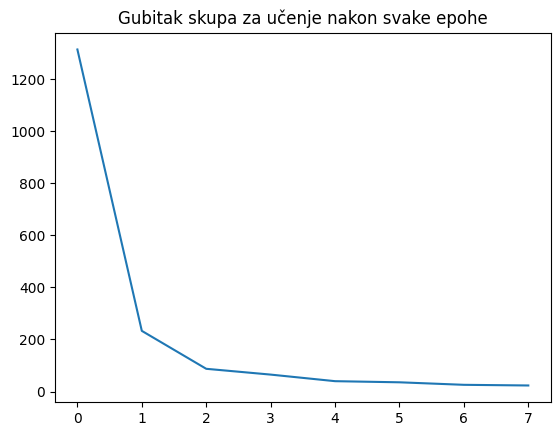

In [ ]:
plt.plot([t for t in trainLosses])
plt.title("Gubitak skupa za učenje nakon svake epohe")

Text(0.5, 1.0, 'Prosječni gubitak skupa za učenje nakon svake epohe')

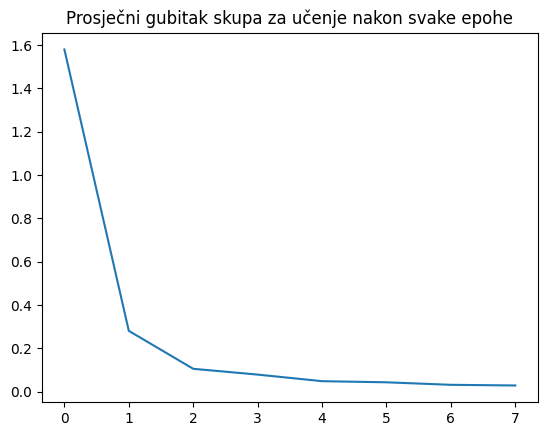

In [3]:
#za potrebe stvaranja grafa čiji se podaci mogu usporediti sa onima na skupu za testiranje (prosječni gubitak svake serije)
#vrijednosti su hardkodirane da se ne mora opet provoditi cijelo učenje
average_train_losses = ([0.04933879093208292, 0.008751510095316916, 0.003278475689636012, 0.0024429375275269614,
                         0.0014941583870891405, 0.0013309646692450715, 0.000968453017920691, 0.00087314478444462])
plt.plot([t * 32 for t in average_train_losses])
plt.title("Prosječni gubitak skupa za učenje nakon svake epohe")

Text(0.5, 1.0, 'Gubitak skupa za testiranje nakon svake epohe')

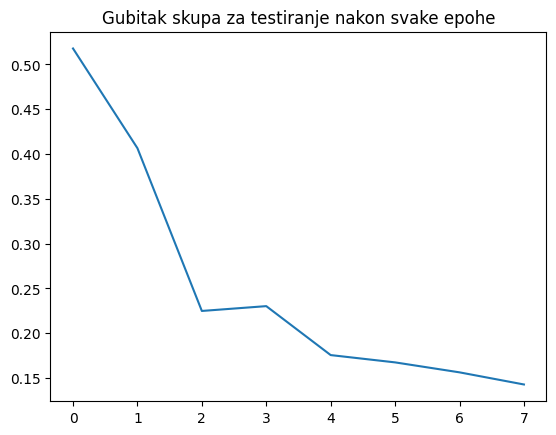

In [ ]:
plt.plot([t for t in testLosses])
plt.title("Gubitak skupa za testiranje nakon svake epohe")

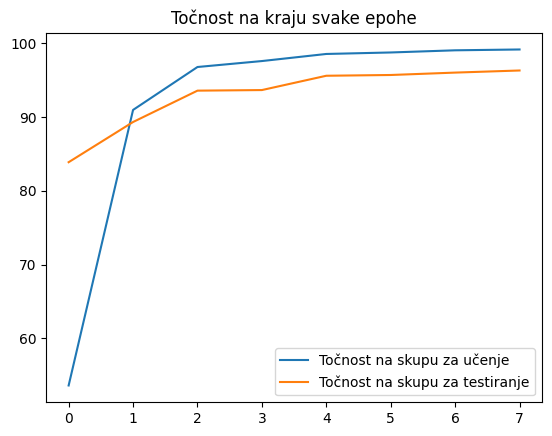

In [ ]:
plt.plot([t / len(train_data) * 100 for t in trainCorrect], label = "Točnost na skupu za učenje")
plt.plot([t / len(y_test) * 100 for t in testCorrect], label = "Točnost na skupu za testiranje")
plt.title("Točnost na kraju svake epohe")
plt.legend()

In [ ]:
model = ConvolutionalNetwork()
model.load_state_dict(torch.load('TrafficSignsCNN2.pth'))
model.eval()

ConvolutionalNetwork(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=6272, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=43, bias=True)
)

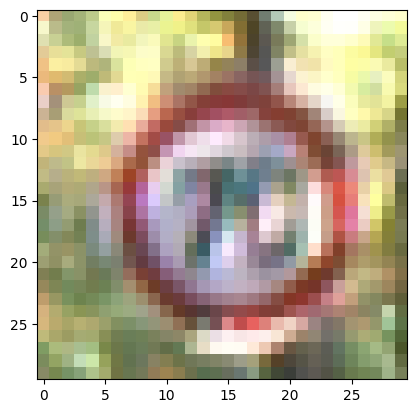

Predicted: tensor(1)
Actual number: tensor(4)


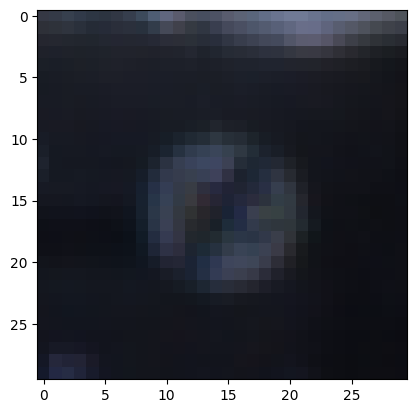

Predicted: tensor(12)
Actual number: tensor(6)


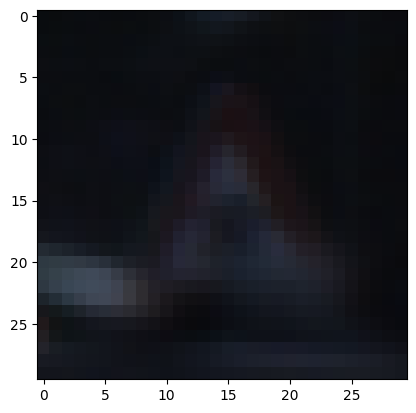

Predicted: tensor(27)
Actual number: tensor(30)


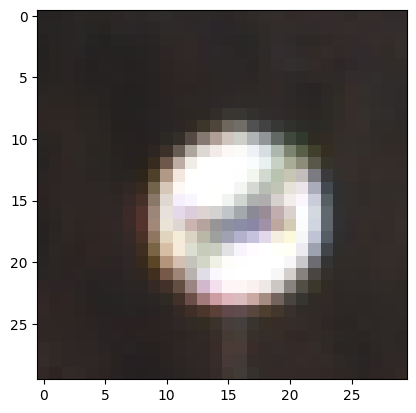

Predicted: tensor(9)
Actual number: tensor(41)


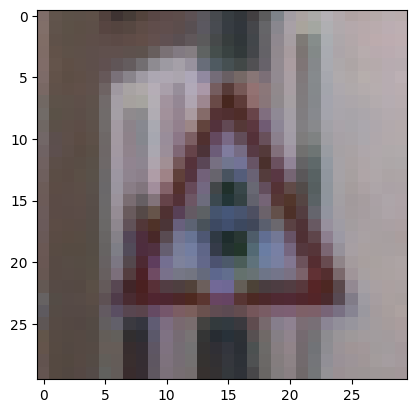

Predicted: tensor(30)
Actual number: tensor(11)


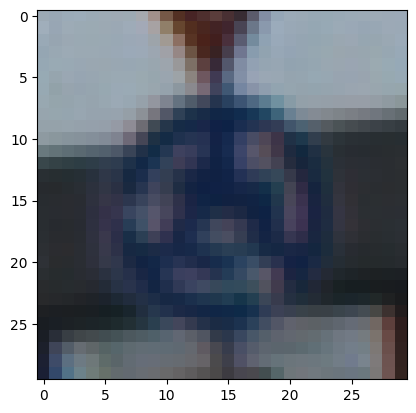

Predicted: tensor(38)
Actual number: tensor(40)


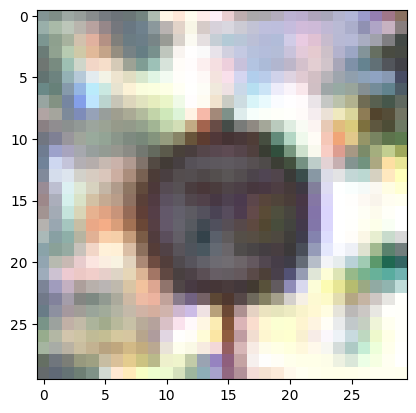

Predicted: tensor(1)
Actual number: tensor(4)


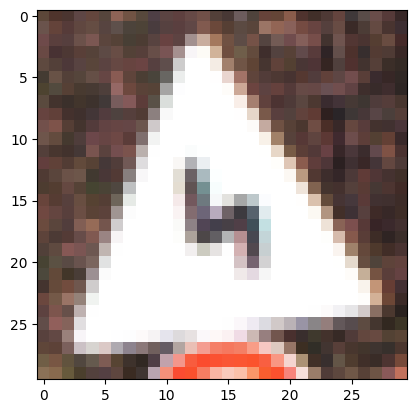

Predicted: tensor(23)
Actual number: tensor(21)


In [ ]:
model.eval()
for i in range(11, 12630, 50):
  with torch.no_grad():
    new_prediction = model(test_data[i][0].view(1,3,30,30))
  if new_prediction.argmax() != y_test[i]: #pogrešna predviđanja
    plt.imshow(test_data[i][0].permute(1, 2, 0))
    plt.show()
    print("Predicted:", new_prediction.argmax())
    print("Actual number:", y_test[i])